# Практическая работа по анализу временных рядов

Используйте датасет из папки

1. Визуализируйте временные ряды каждого продукта
2. Проанализируйте, есть ли в данных пропуски? Заполните пропуски описанными ниже методами и добавьте столбцы с заполненными значениями к датасету.
- заполните пропуски нулями
- заполните пропуски средними значениями
- заполните с помощью метода ffill
- заполните с помощью интерполяции .interpolate()
3. используя функцию .resample() произведите даунсемплинг. Сохраните этот датасет отдельным файлом.
- до недели
- до месяца
4. Проанализируйте, есть ли в данных выбросы. Анализировать нужно преобразованный ряд в п.2. Тот, который на ваш взгляд больше похож на реальный.
- Изучите библиотеку pyod, разберитесь в импортированных модулях.
- Протестируйте каждый из методов, выберите тот, который на ваш взгляд лучше всего определяет аномалии в датасете
- Визуализируйте аномалии по примеру ниже:
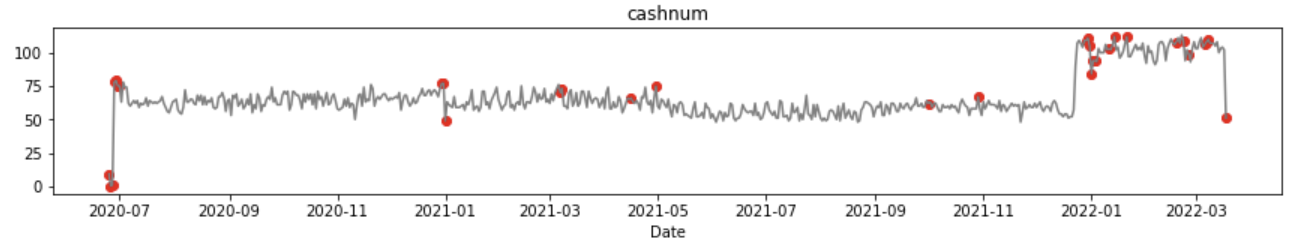
- Все аномальные точки замените с помощью метода ffill или .interpolate() (ИСКЛЮЧЕНИЕ ПРАЗДНИКИ И ПРЕДПРАЗДНИЧНЫЕ ДНИ)

1. Визуализируйте временные ряды каждого продукта

In [144]:
import numpy as np
import pandas as pd

import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX

import pickle


In [145]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [146]:
df = pd.read_csv(
    '99000000000_train.csv',
    sep=';',
    decimal=',',
    thousands=chr(160),  # non-breakable space
    engine='python',  # for non-breakable space to work as thousands separator https://stackoverflow.com/questions/64336254/use-non-breakable-space-as-thousands-separator-in-pandas-read-csv-function
)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df.rename(columns={'сabbage': 'cabbage'}, inplace=True)
df.sort_values(by='date', inplace=True)
df = df.drop(columns=['oktmo'])
df

,date,pasta,legumes,bread,flour,rice,groats,potatoes,сucumbers_tomatoes,vegetables,...,spice_value,tea_value,ai92,ai95,ai98,dt,ai92_value,ai95_value,ai98_value,dt_value
0,2019-01-01,54.86,100.18,69.28,0.00,0.00,27.94,23.55,170.93,28.70,...,647.00,544.00,41.84,43.72,44.20,0.00,22559.14,12821.38,902.44,0.00
1,2019-01-02,65.45,103.95,72.14,30.25,53.62,31.96,25.35,161.89,27.66,...,2210.58,1617.00,41.97,43.77,44.20,53.25,34219.31,22421.01,1037.14,306.24
2,2019-01-03,57.11,98.28,72.61,29.44,45.17,33.54,24.29,159.71,27.16,...,2590.43,2161.30,42.11,43.87,44.52,53.49,40634.24,25086.21,1211.33,4894.56
3,2019-01-04,59.07,98.09,72.57,30.62,57.60,30.12,25.26,156.75,27.10,...,3093.49,2033.00,42.08,43.89,44.65,53.46,41623.68,26616.56,1565.97,5289.08
4,2019-01-05,56.12,100.54,71.98,29.06,54.34,31.49,25.29,156.97,27.23,...,3445.21,2078.00,42.39,44.27,45.25,53.49,40964.10,24650.02,1475.59,2554.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,2021-03-27,77.58,121.54,81.34,37.40,78.39,39.51,54.05,202.55,60.56,...,4125.94,2602.20,47.60,49.25,51.44,53.26,41167.61,31331.44,2494.75,920.75
817,2021-03-28,78.62,121.63,80.83,36.19,83.00,56.50,53.92,189.76,49.64,...,3846.06,2297.06,47.44,49.21,51.48,53.29,37482.06,31589.46,2790.93,601.82
818,2021-03-29,74.99,129.61,84.02,36.28,81.07,46.49,54.63,193.77,47.05,...,3299.10,2193.18,47.55,49.28,51.07,53.29,39841.92,29342.31,3133.55,1261.53
819,2021-03-30,78.50,127.97,93.25,38.26,75.21,43.16,54.10,189.46,38.87,...,3908.00,2533.01,47.22,49.27,51.42,53.37,41248.79,31276.10,2713.71,1223.88


In [147]:
df= df.head(400)

<Axes: xlabel='date', ylabel='chicken'>

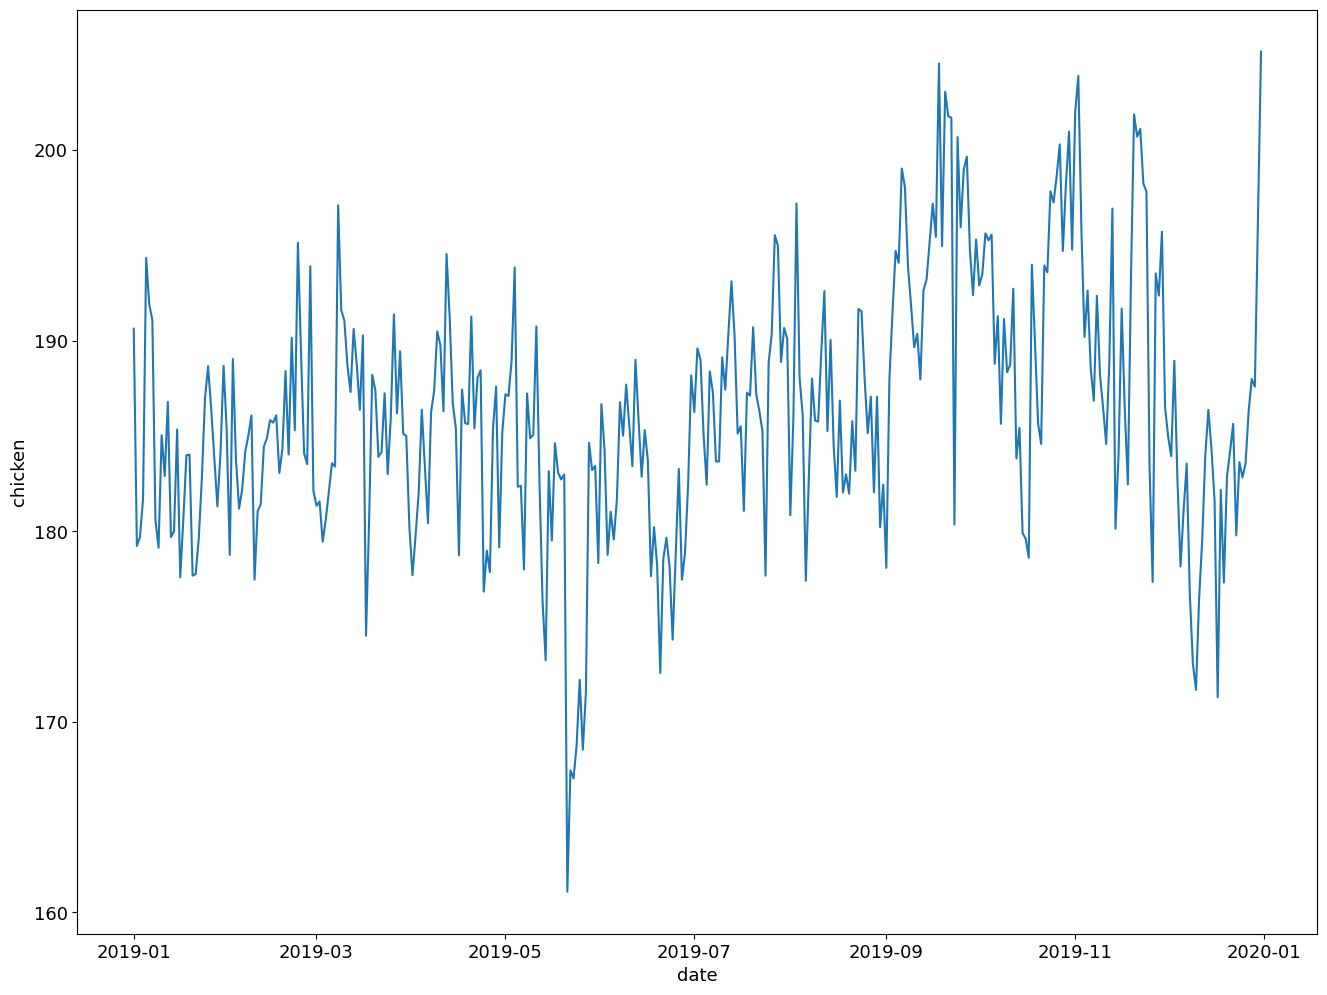

In [148]:
sns.lineplot(data=df, x='date', y='chicken')

2. Разберёмся с аутлаерами. Нулевые значения, заменим на NaN.

In [149]:
for product in df.columns[1:]:
    logging.info(f'Processing {product}. {(df[product] == 0).sum()} zero values')
    df.loc[df[product] == 0, product] = np.nan

2025-02-08 17:35:20,307 : INFO : Processing pasta. 0 zero values
2025-02-08 17:35:20,311 : INFO : Processing legumes. 0 zero values
2025-02-08 17:35:20,312 : INFO : Processing bread. 0 zero values
2025-02-08 17:35:20,313 : INFO : Processing flour. 1 zero values
2025-02-08 17:35:20,315 : INFO : Processing rice. 1 zero values
2025-02-08 17:35:20,316 : INFO : Processing groats. 0 zero values
2025-02-08 17:35:20,318 : INFO : Processing potatoes. 0 zero values
2025-02-08 17:35:20,320 : INFO : Processing сucumbers_tomatoes. 0 zero values
2025-02-08 17:35:20,322 : INFO : Processing vegetables. 0 zero values
2025-02-08 17:35:20,324 : INFO : Processing roots. 0 zero values
2025-02-08 17:35:20,325 : INFO : Processing cabbage. 2 zero values
2025-02-08 17:35:20,327 : INFO : Processing fruit. 0 zero values
2025-02-08 17:35:20,329 : INFO : Processing sugar. 0 zero values
2025-02-08 17:35:20,331 : INFO : Processing candy. 0 zero values
2025-02-08 17:35:20,335 : INFO : Processing biscuits. 0 zero valu

<Axes: xlabel='date', ylabel='fish_value'>

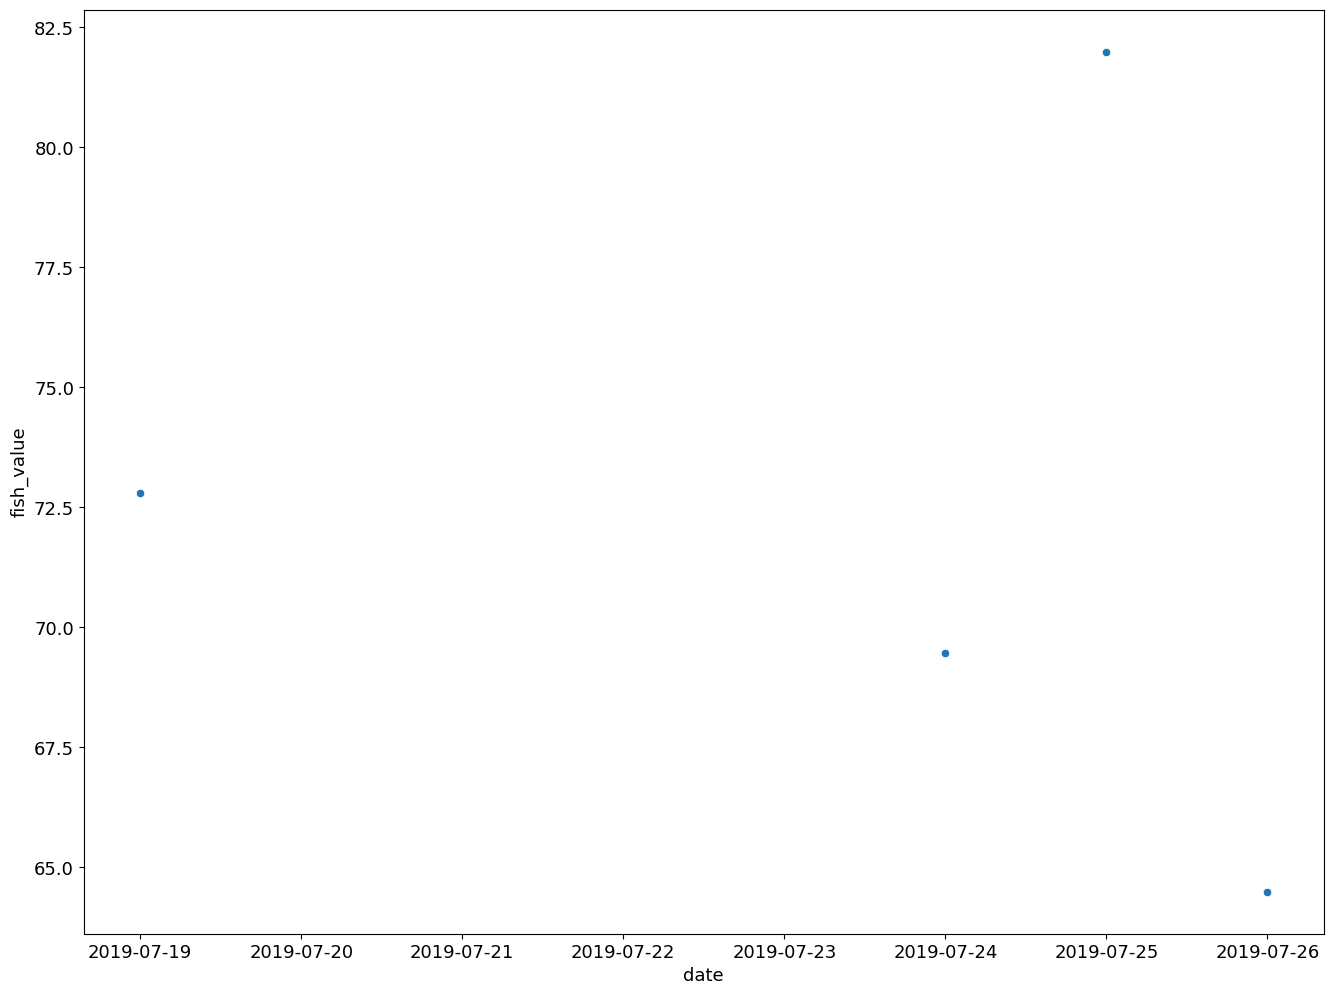

In [150]:
sns.scatterplot(data=df, x='date', y='fish_value')

3. используя функцию .resample() произведите даунсемплинг. Сохраните этот датасет отдельным файлом.
- до недели
- до месяца

In [151]:
df_downsample_week = df.resample('W', on='date').mean()
df_downsample_month = df.resample('M', on='date').mean()

df_downsample_week.to_csv('99000000000_train_week.csv')
df_downsample_month.to_csv('99000000000_train_month.csv')

4. Проанализируйте, есть ли в данных выбросы. Анализировать нужно преобразованный ряд в п.2. Тот, который на ваш взгляд больше похож на реальный.
- Изучите библиотеку pyod, разберитесь в импортированных модулях.
- Протестируйте каждый из методов, выберите тот, который на ваш взгляд лучше всего определяет аномалии в датасете
- Визуализируйте аномалии по примеру ниже:
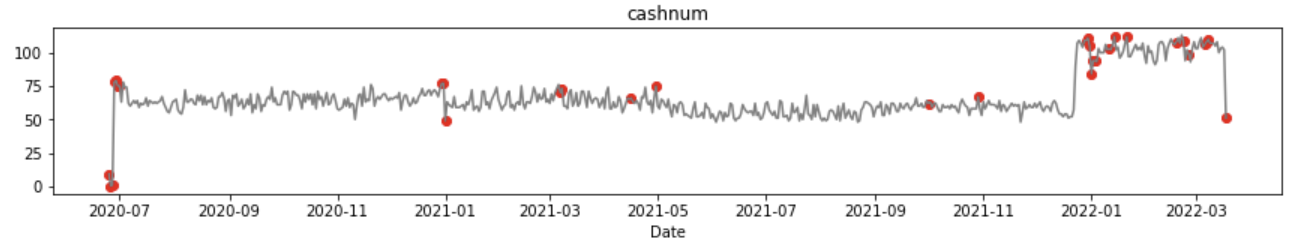
- Все аномальные точки замените с помощью метода ffill или .interpolate() (ИСКЛЮЧЕНИЕ ПРАЗДНИКИ И ПРЕДПРАЗДНИЧНЫЕ ДНИ)

In [152]:
import pyod

from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.pca import PCA

In [153]:
df.columns

Index(['date', 'pasta', 'legumes', 'bread', 'flour', 'rice', 'groats',
       'potatoes', 'сucumbers_tomatoes', 'vegetables', 'roots', 'cabbage',
       'fruit', 'sugar', 'candy', 'biscuits', 'mutton', 'beef', 'chicken',
       'pork', 'fish', 'herring', 'curd', 'sour_creame', 'butter',
       'milk_kefir', 'cheese', 'egg', 'margarine', 'oil', 'salt', 'spice',
       'tea', 'cpi_1', 'cpi_2', 'cpi_3', 'pasta_value', 'legumes_value',
       'bread_value', 'flour_value', 'rice_value', 'groats_value',
       'potatoes_value', 'сucumbers_tomatoes_value', 'vegetables_value',
       'roots_value', 'сabbage_value', 'fruit_value', 'sugar_value',
       'candy_value', 'biscuits_value', 'mutton_value', 'beef_value',
       'chicken_value', 'pork_value', 'fish_value', 'herring_value',
       'curd_value', 'sour_creame_value', 'butter_value', 'milk_kefir_value',
       'cheese_value', 'egg_value', 'margarine_value', 'oil_value',
       'salt_value', 'spice_value', 'tea_value', 'ai92', 'ai95', 'ai98

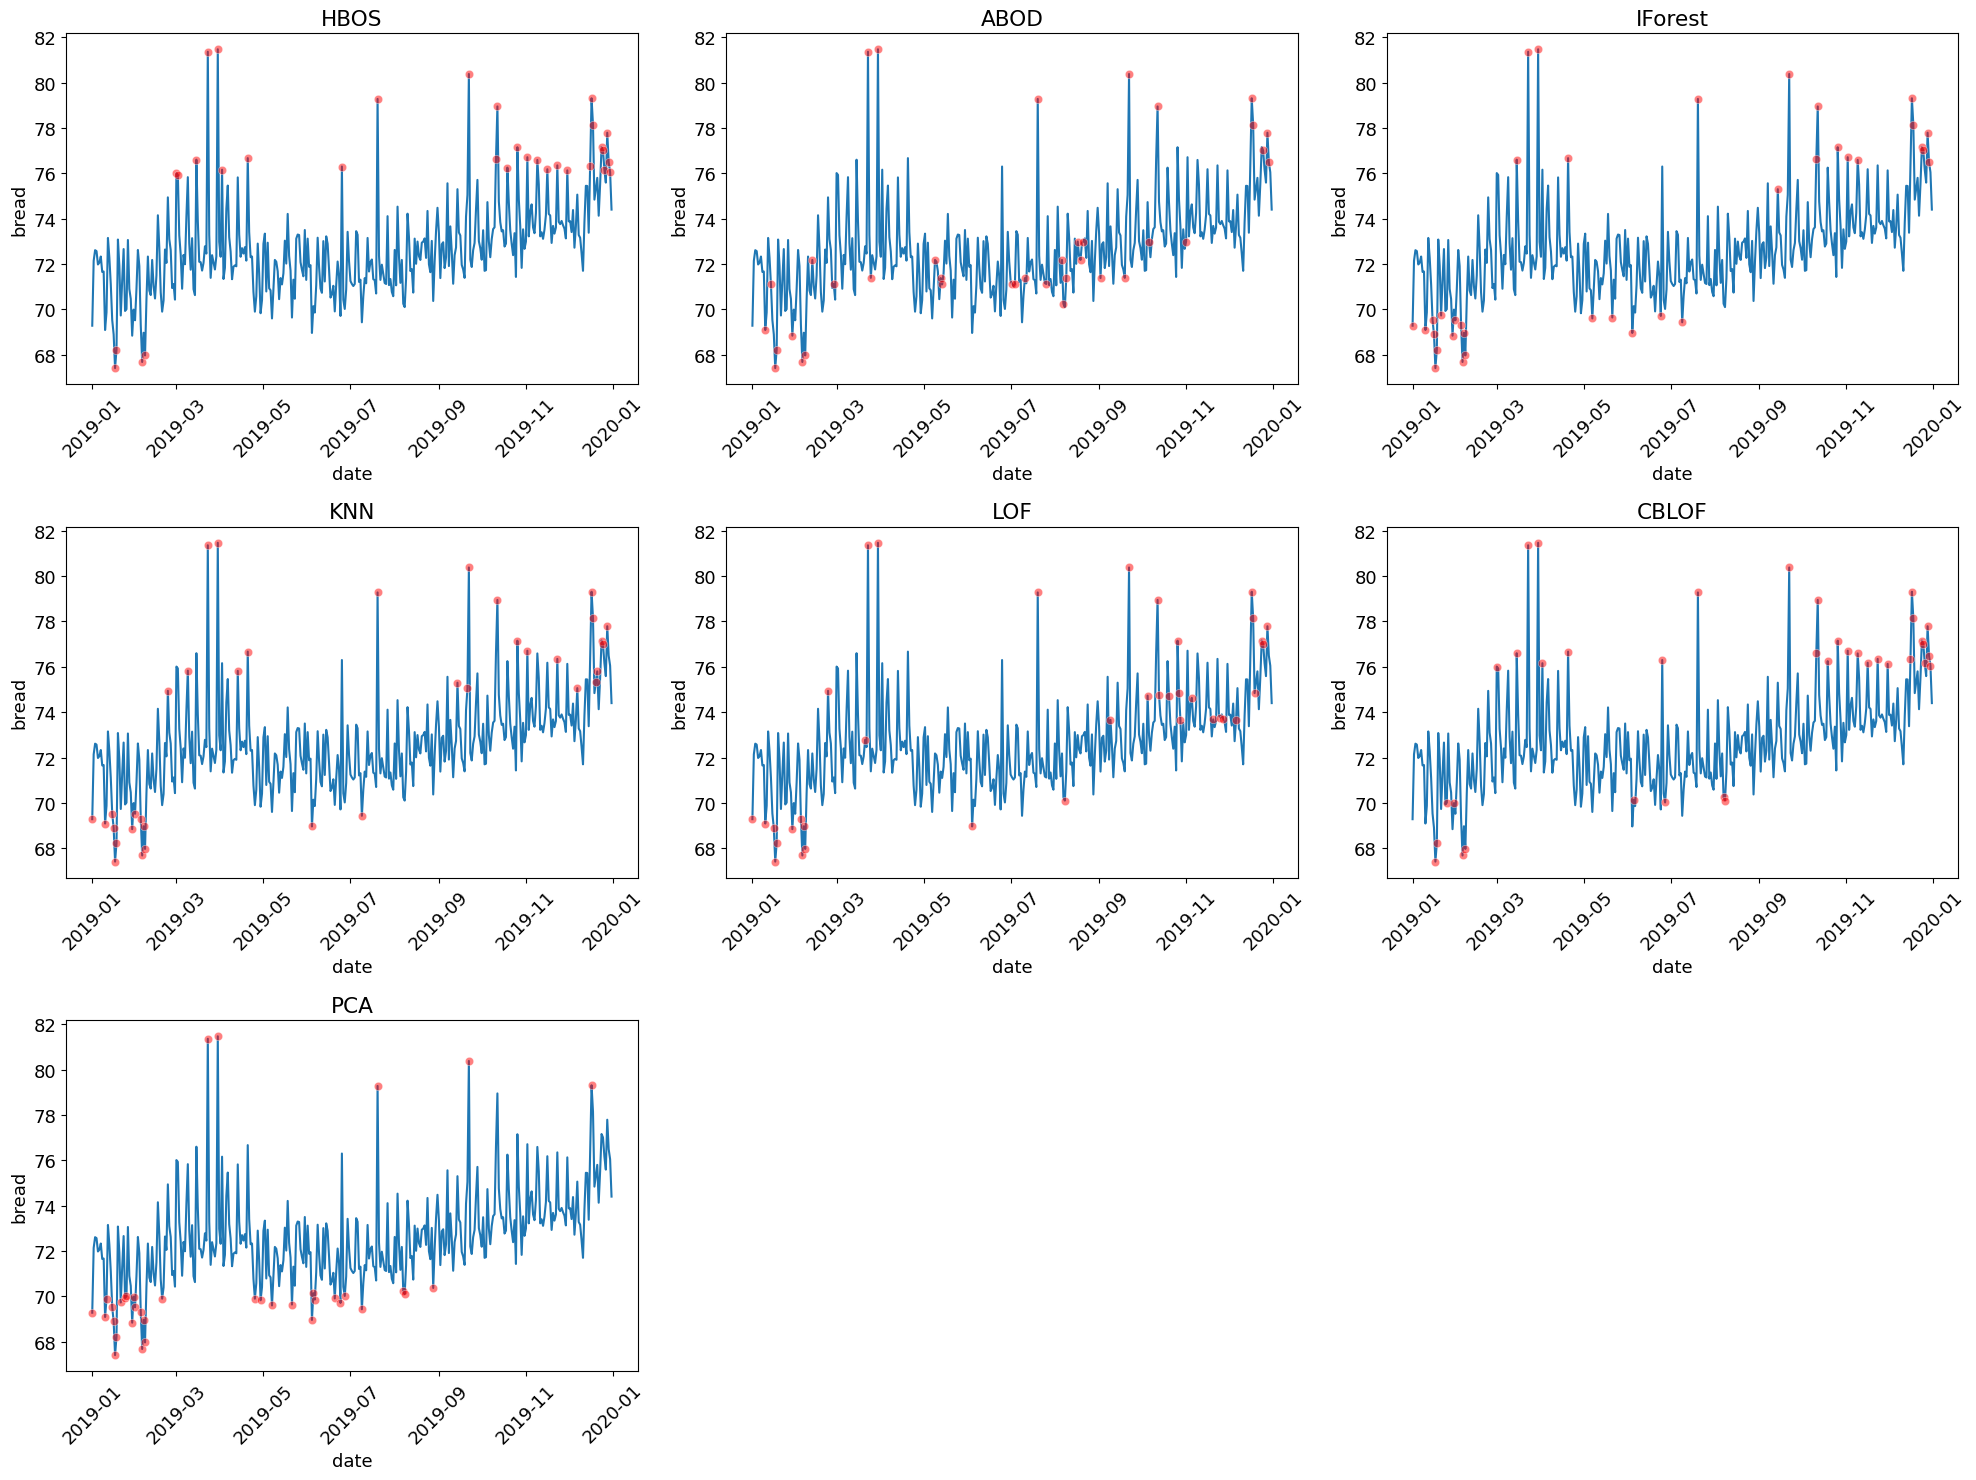

In [154]:
product = 'bread'

x = df[product].to_numpy()

knn = KNN();
knn.fit(x.reshape(-1, 1))

models = [
    HBOS(),
    ABOD(),
    IForest(),
    KNN(),
    LOF(),
    CBLOF(),
    PCA(),
]

for model in models:
    model.fit(x.reshape(-1, 1))

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, model in enumerate(models):
    ax = axs[i // 3, i % 3]
    ax.set_title(model.__class__.__name__)
    sns.lineplot(data=df, x='date', y=product, zorder=0, ax=ax)
    sns.scatterplot(df[model.labels_ == 1], x='date', y=product, color='red', zorder=1, alpha=0.5, ax=ax)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45 )

[ax.set_visible(False) for ax in axs.flatten()[len(models):]]
plt.tight_layout()


RandomForestRegressor()



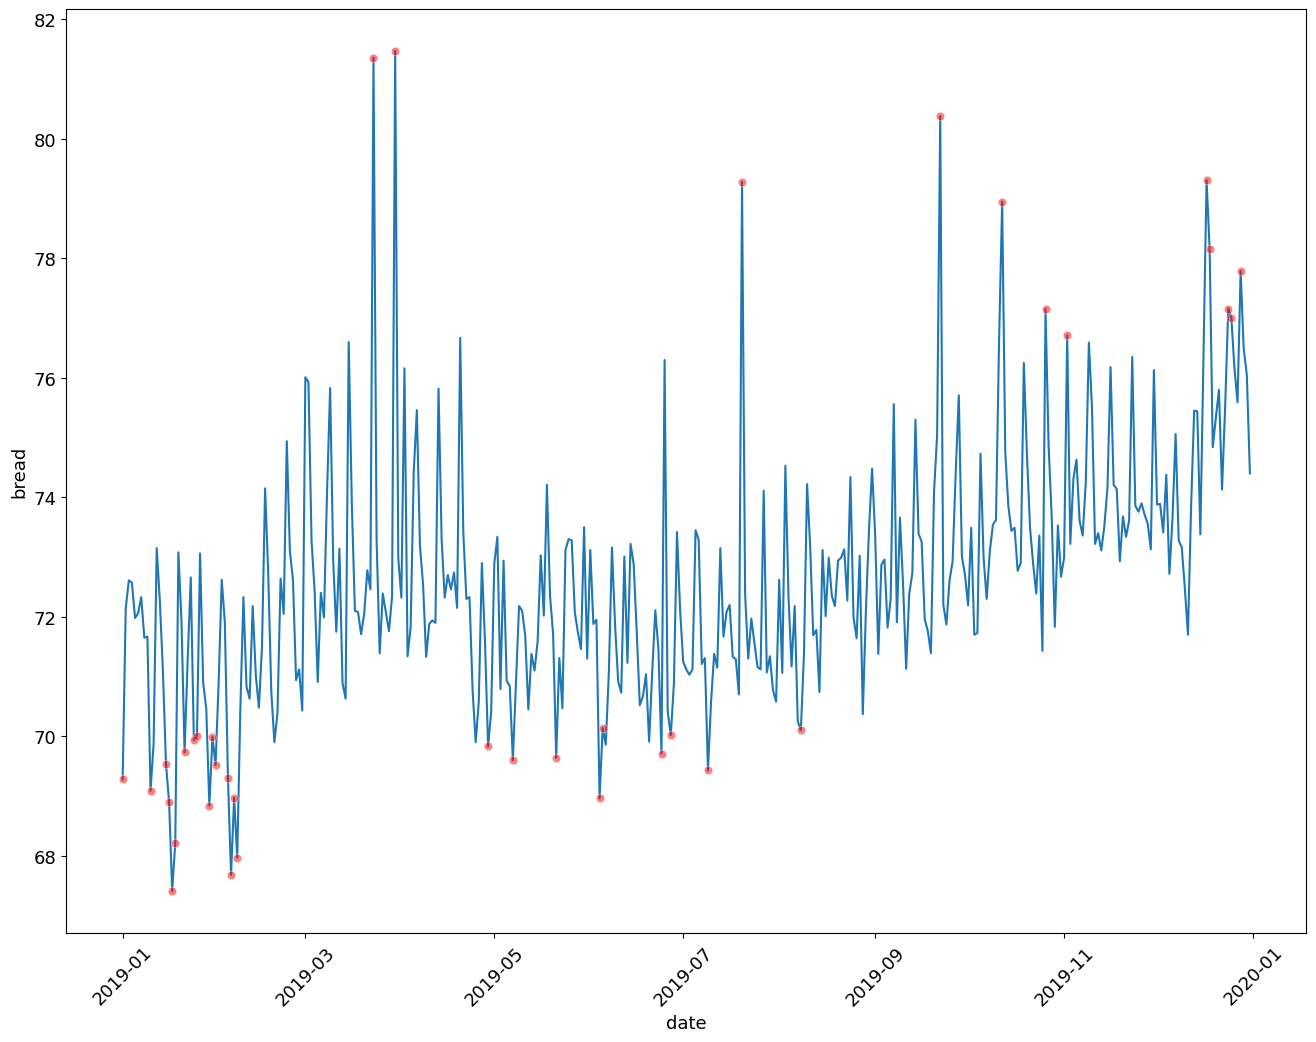

In [155]:
from pyod.models.suod import SUOD

suod = SUOD(base_estimators=models, combination='average')
suod.fit(x.reshape(-1, 1))

sns.lineplot(data=df, x='date', y=product, zorder=0)
sns.scatterplot(df[suod.labels_ == 1], x='date', y=product, color='red', zorder=1, alpha=0.5)
plt.xticks(rotation=45);

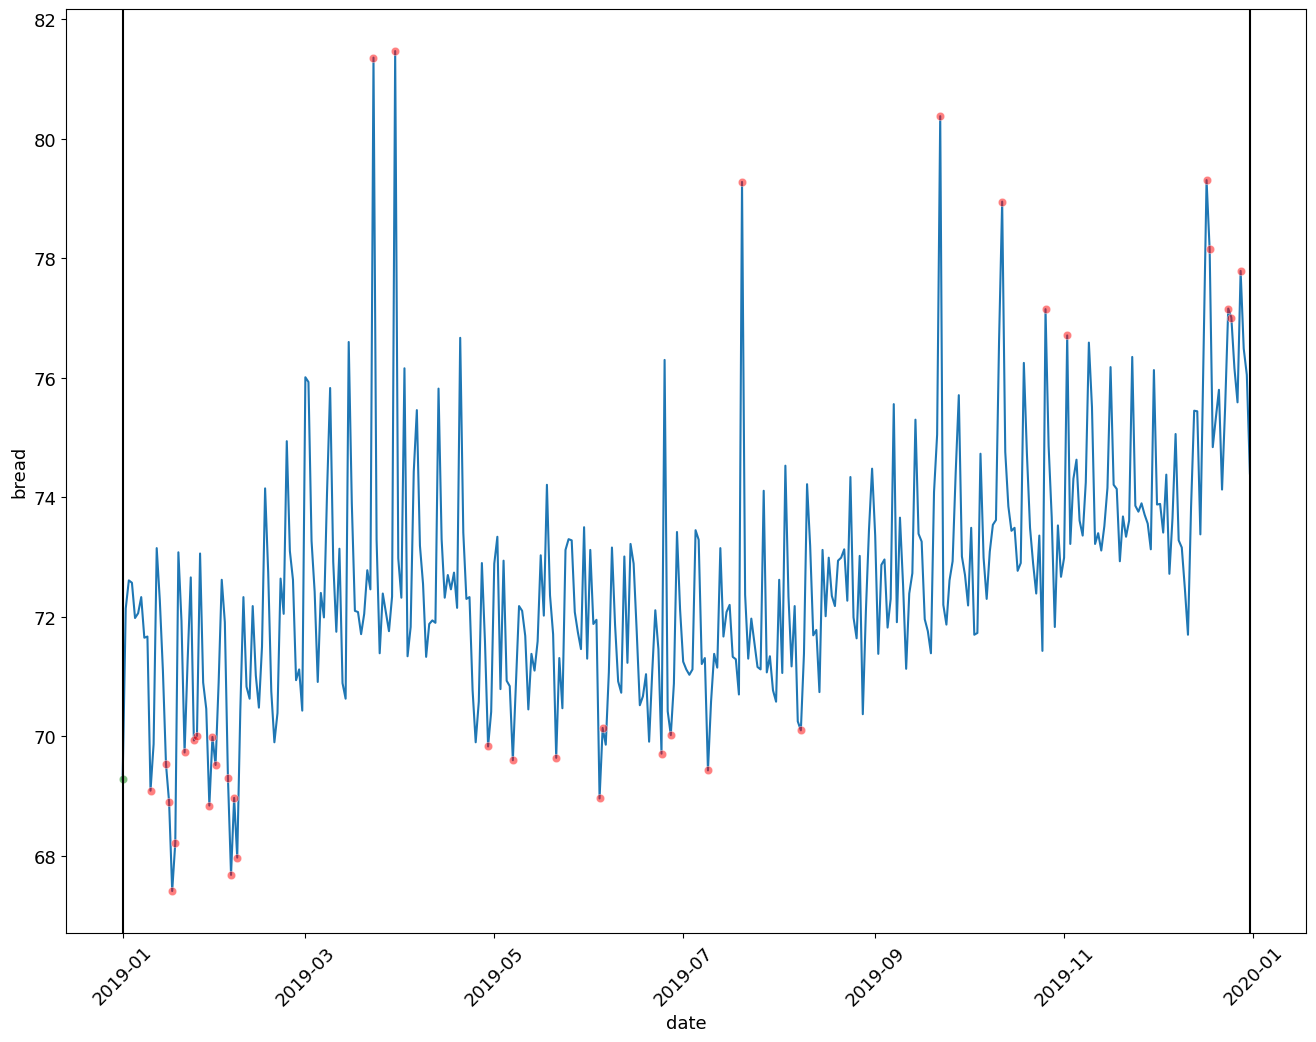

In [156]:
import holidays
import datetime as dt

df['is_holiday_or_preholiday'] = df['date'].apply(lambda x: x in holidays.RU())
# предпраздничные дни
df['is_holiday_or_preholiday'] = df['is_holiday_or_preholiday'] | df['is_holiday_or_preholiday'].shift(-1).fillna(False)
true_outliers = (suod.labels_ == 1) & np.invert(df['is_holiday_or_preholiday'])
false_outliers = (suod.labels_ == 1) & df['is_holiday_or_preholiday']

sns.lineplot(data=df, x='date', y=product, zorder=0)
sns.scatterplot(df[true_outliers], x='date', y=product, color='red', zorder=1, alpha=0.5)
sns.scatterplot(df[false_outliers], x='date', y=product, color='green', zorder=1, alpha=0.5)

dates_interval = (df['date'][0], df['date'][len(df) - 1])
plt.axvline(x=dates_interval[0], color='black')
plt.axvline(x=dates_interval[1], color='black')

plt.xticks(rotation=45);

2025-02-08 17:35:25,115 : INFO : 0 NaN values
2025-02-08 17:35:25,117 : INFO : removed outliers: 36 NaN values
2025-02-08 17:35:25,119 : INFO : after interpolation: 0 NaN values


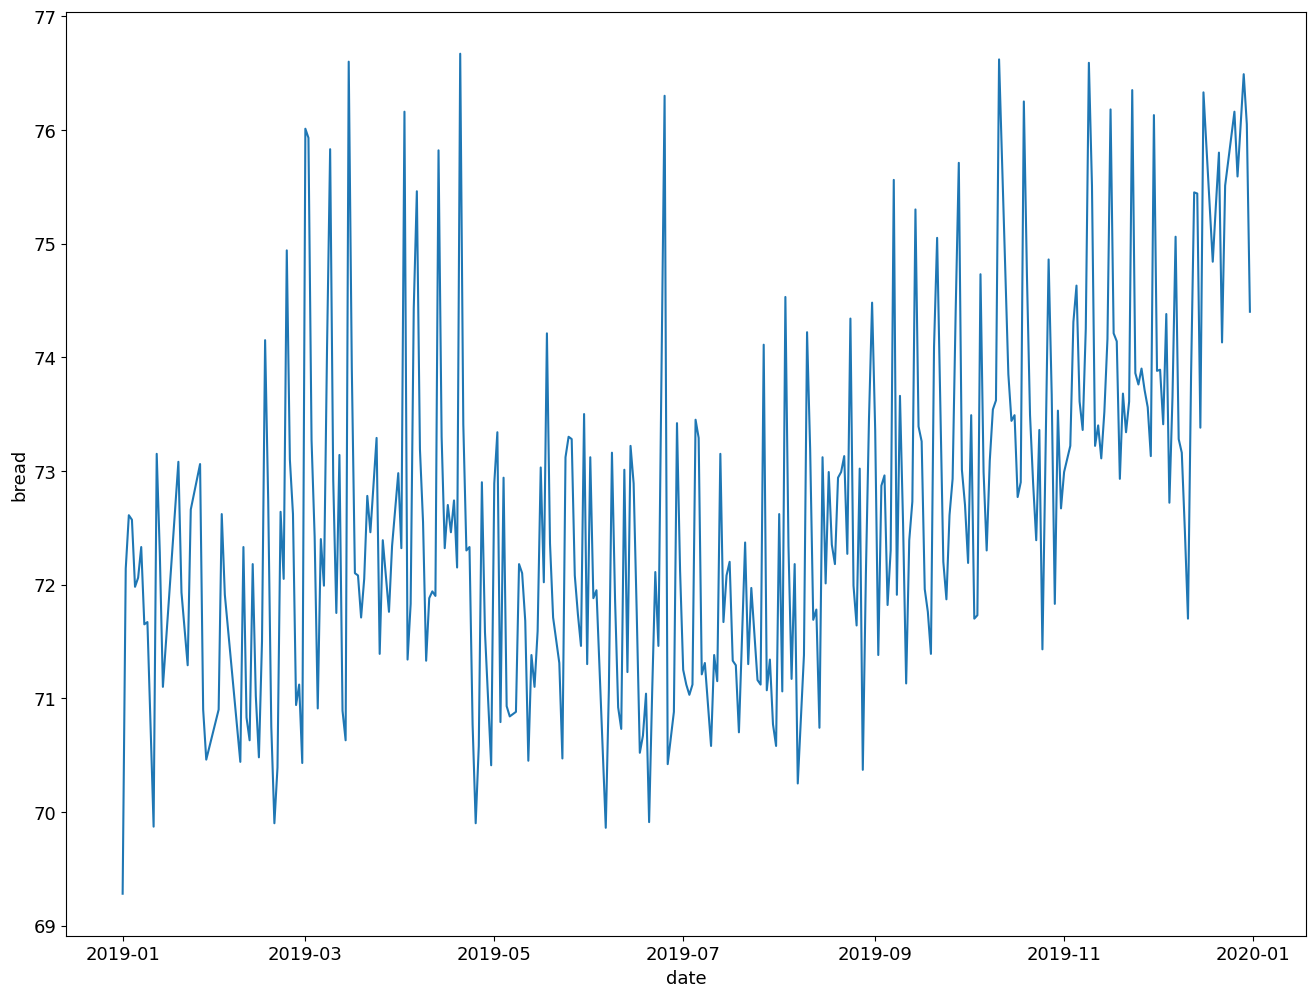

In [157]:
df = df[(df['date'] >= dates_interval[0]) & (df['date'] <= dates_interval[1])]

logging.info(f'{df[product].isna().sum()} NaN values')
df.loc[true_outliers, product] = np.nan
logging.info(f'removed outliers: {df[product].isna().sum()} NaN values')

df[product].interpolate(method='linear', inplace=True, limit_direction='both')
logging.info(f'after interpolation: {df[product].isna().sum()} NaN values')

sns.lineplot(data=df, x='date', y=product, zorder=0);


5. Проверьте стационарность временных рядов с помощью критерия Дики-Фуллера и визуализируйте составляющие ряда

In [158]:
# убедимся, что временные промежутки между данными постоянные (каждый день)

print(df['date'].diff().dt.days.dropna())
assert np.all(df['date'].diff().dt.days.dropna() == 1)

1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
360    1.0
361    1.0
362    1.0
363    1.0
364    1.0
Name: date, Length: 364, dtype: float64


Критерий Дики-Фуллера: p=0.889016


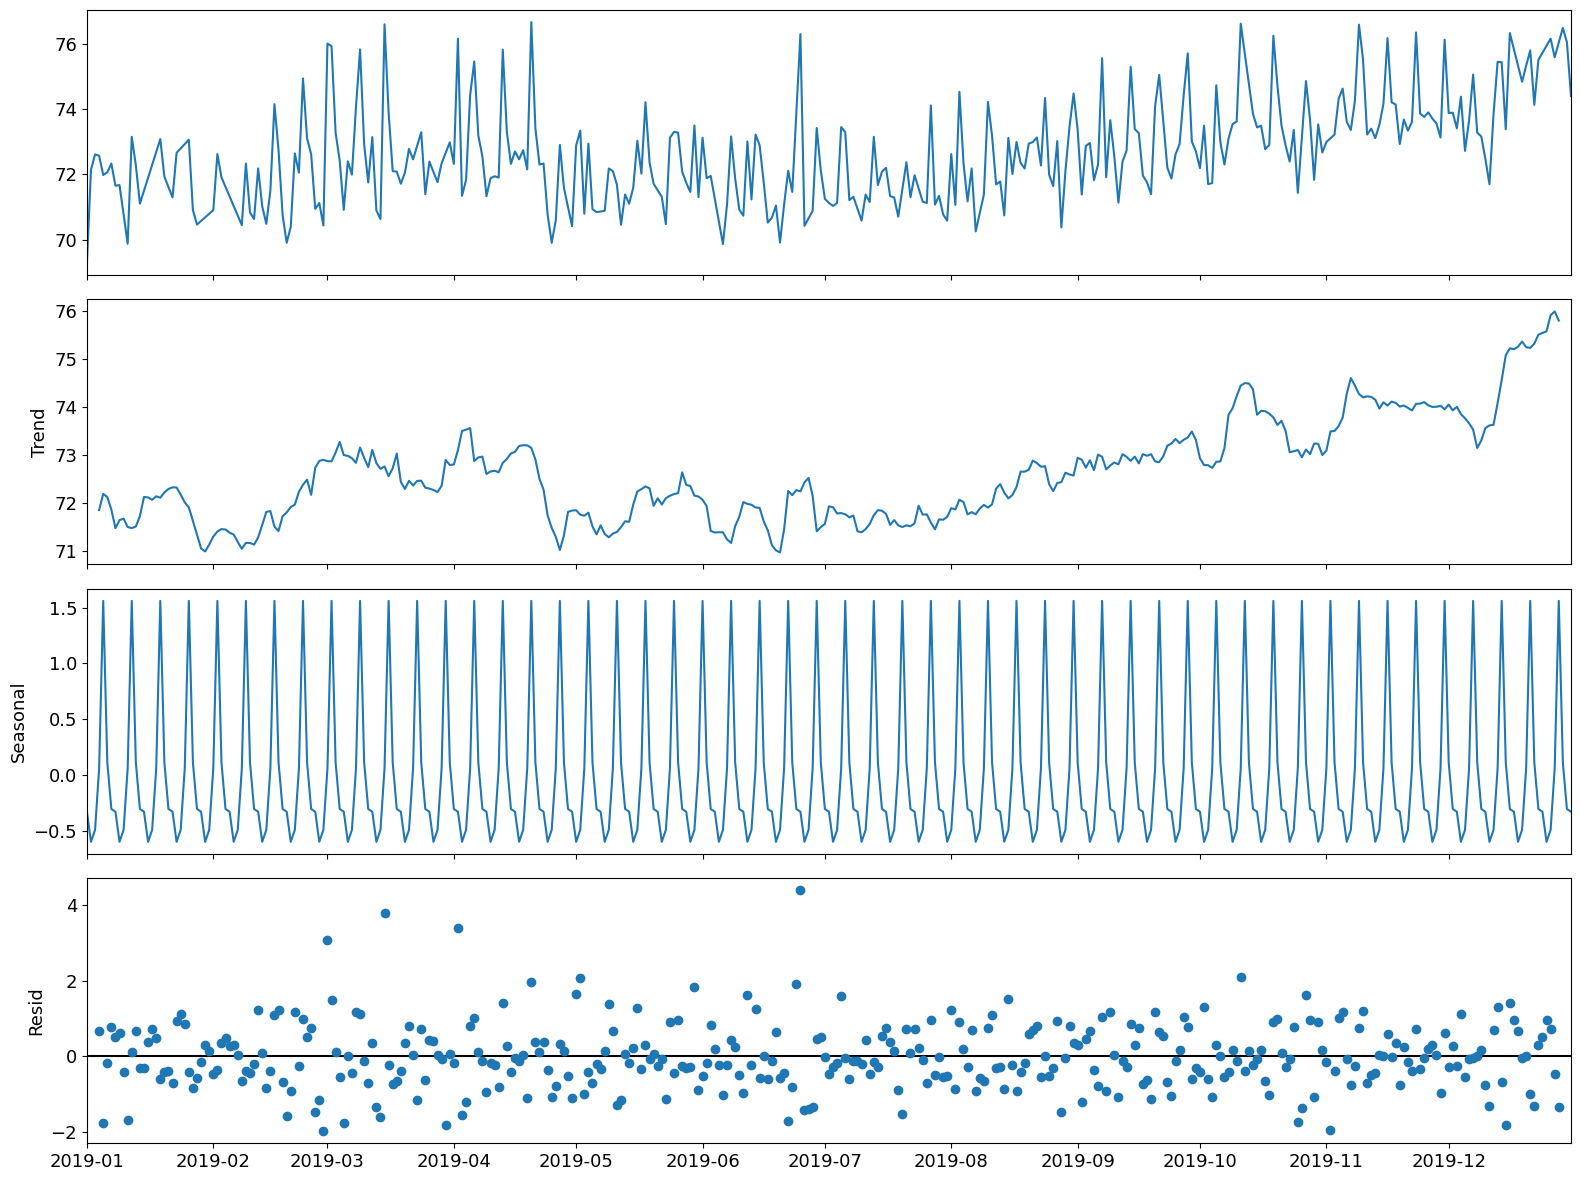

In [159]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters


plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

x = pd.Series(df[product].values, index=df['date'])

sm.tsa.seasonal_decompose(x).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(x)[1])


6. Стабилизация дисперсии

1.5604056739071916
1.3896837628460548e-17


ValueError: Invalid input, x is constant

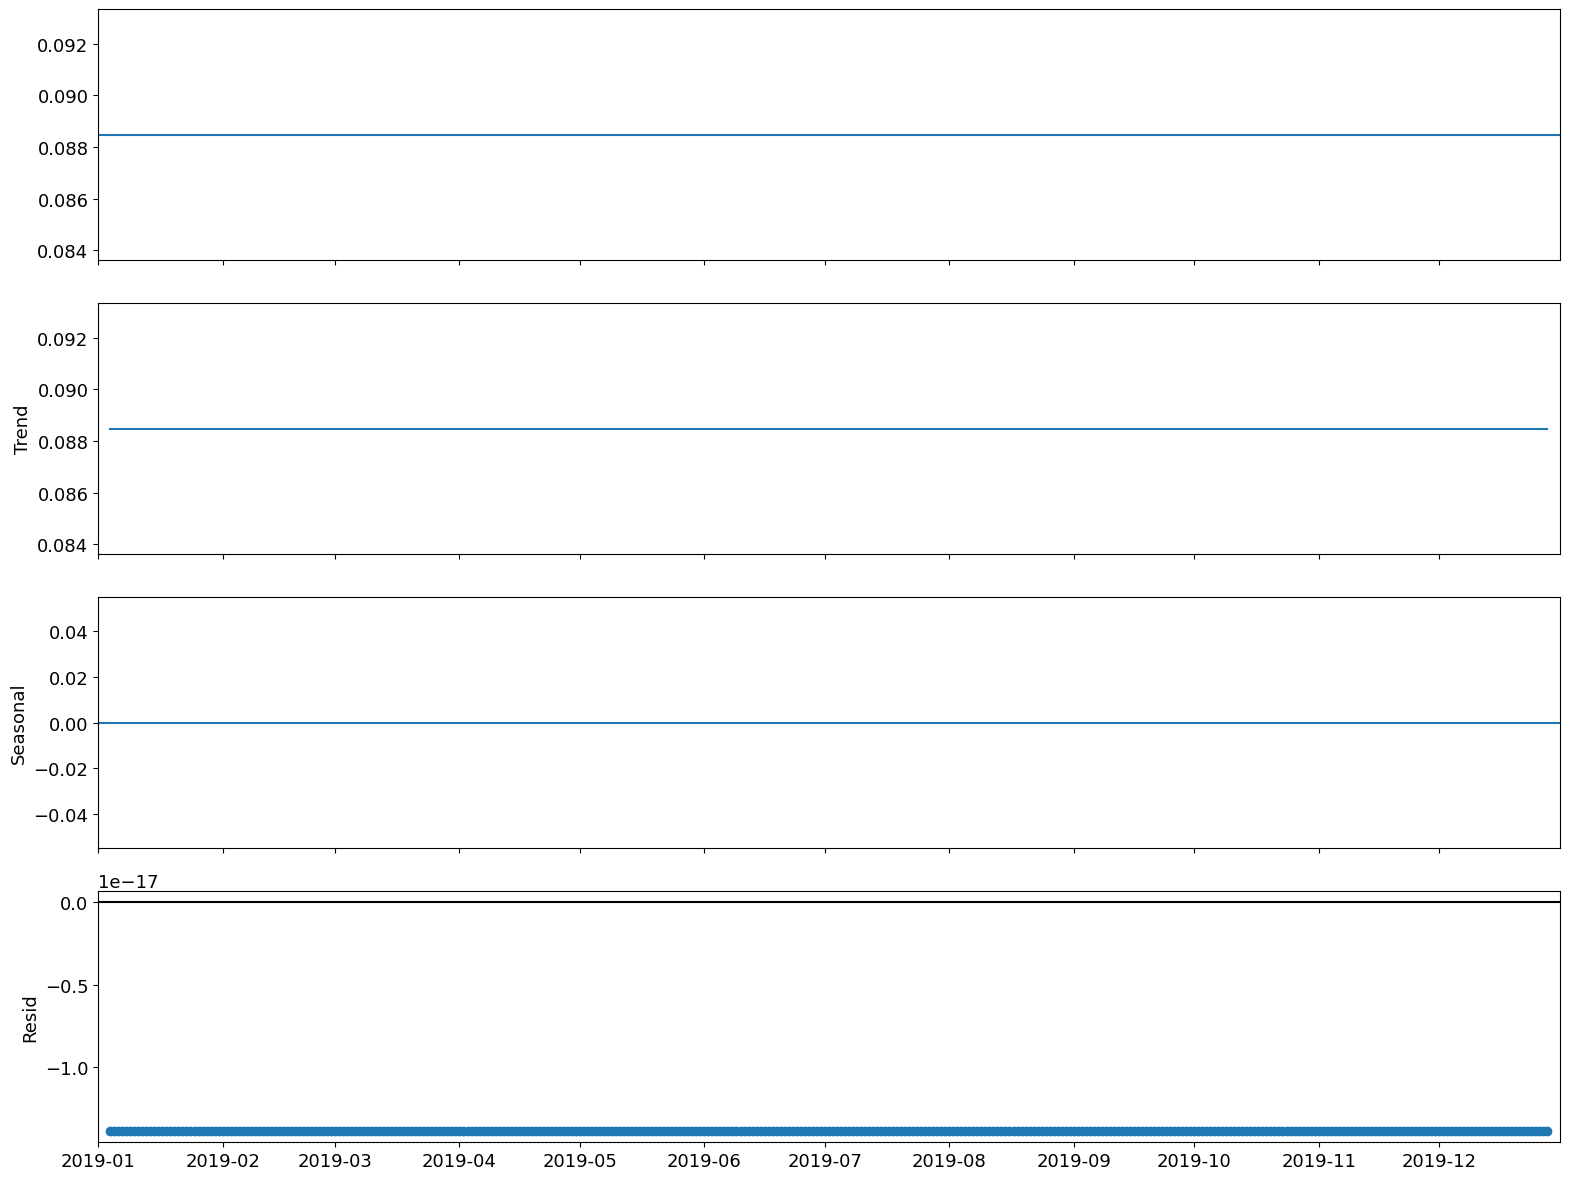

In [160]:
# Сделаем преобразование Бокса-Кокса для стабилизации дисперсии и посмотрим на критерий Дики-Фуллера снова

from scipy.stats import boxcox
print(x.std())
x_boxcox = pd.Series(boxcox(x)[0], index=x.index)
# x_boxcox = x
print(x_boxcox.std())
sm.tsa.seasonal_decompose(x_boxcox).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(x_boxcox)[1])

7. Стационарность

In [54]:
# Если критерий Дики-Фуллера после преобразований отвергает гипотезу о стационарности, то тогда необходимо дифференцировать ряд
# Есть несколько видов дифференцирования
# Обычное - time_series - time_series.shift(1)
# Сезонное - time_series - time_series.shift(7 - для недели, 29,8 - для месяца и тд)
# ПАрробуйте, начиная с обычного и далее, пока все ряды не станут стационарными

Критерий Дики-Фуллера: p = 9.875256233760635e-18
0.009882868754350904

Критерий Дики-Фуллера: p = 4.962030952806492e-13
0.009016906005722192

Критерий Дики-Фуллера: p = 0.000698937002273082
0.012864512259745501

Критерий Дики-Фуллера: p = 2.1114902261900415e-19
0.01102188559787203



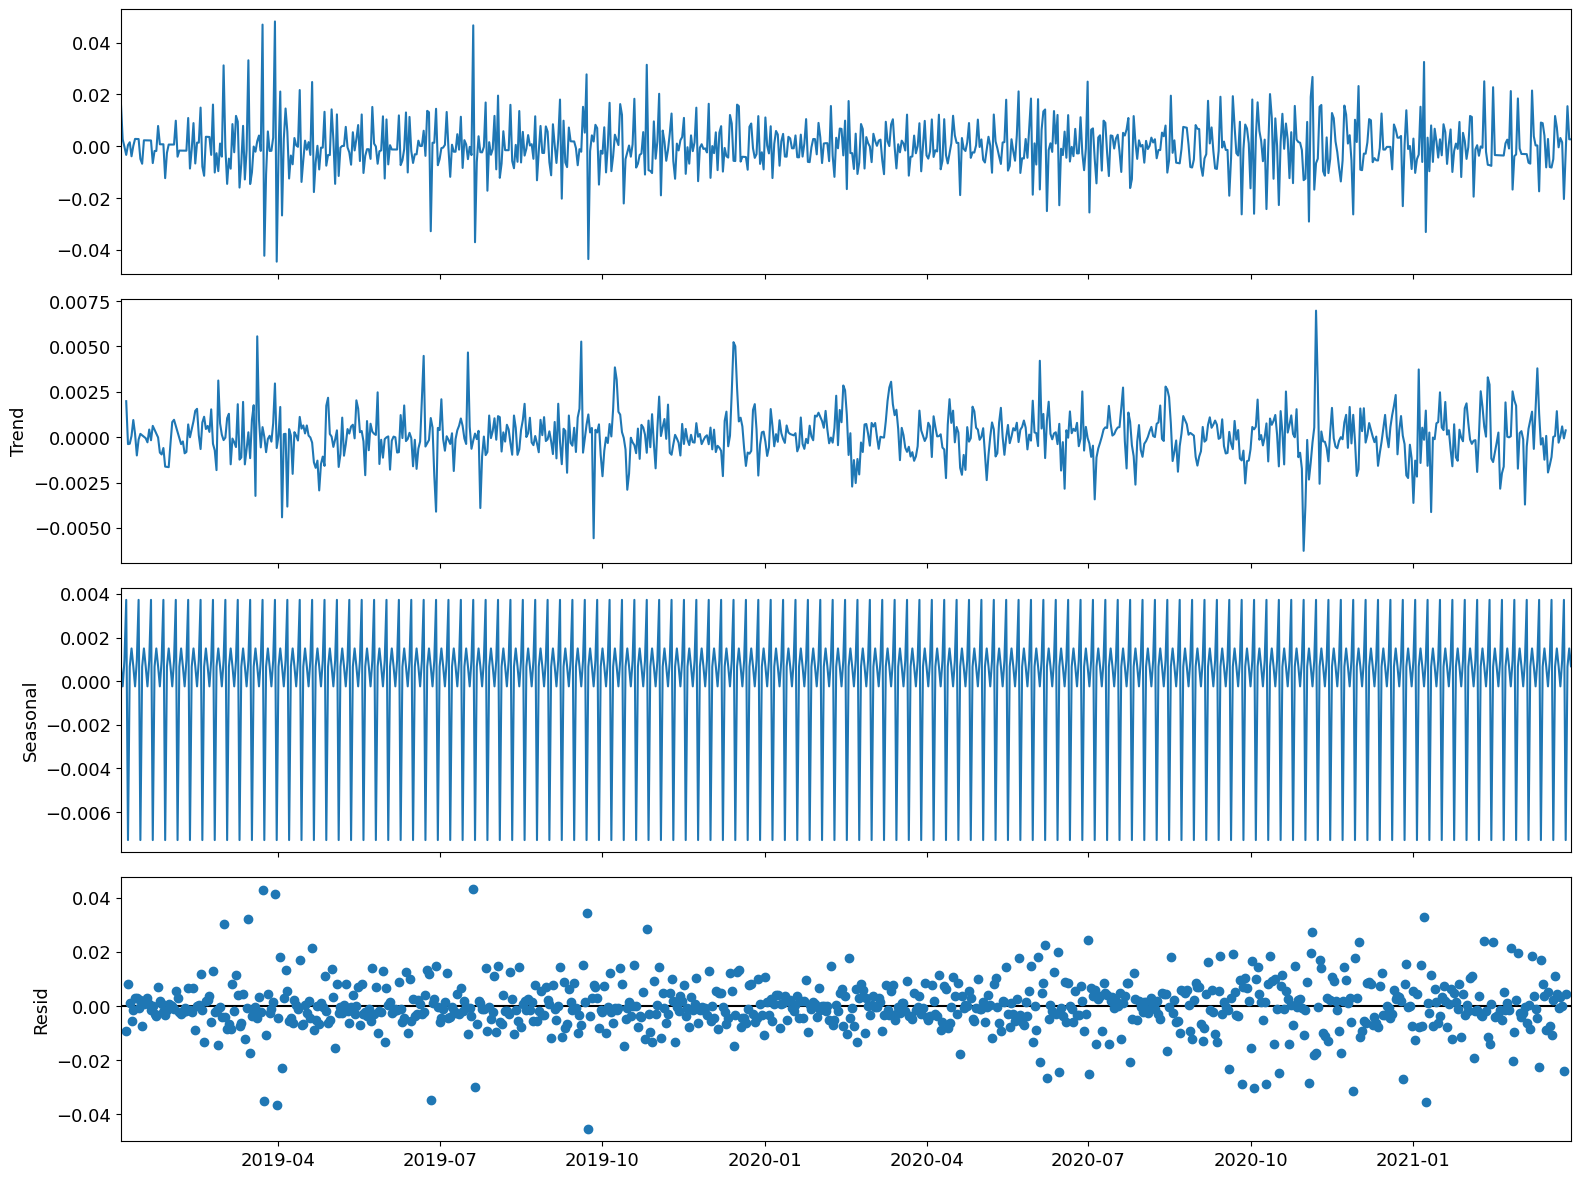

In [ ]:
x_boxcox_diff_1 = x_boxcox.diff(1).dropna()
print(f'Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(x_boxcox_diff_1)[1]}')
sm.tsa.seasonal_decompose(x_boxcox_diff_1).plot()
print(x_boxcox_diff_1.std())
print()

x_boxcox_diff_7 = x_boxcox.diff(7).dropna()
print(f'Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(x_boxcox_diff_7)[1]}')
# sm.tsa.seasonal_decompose(x_boxcox_diff_7).plot()
print(x_boxcox_diff_7.std())
print()

x_boxcox_diff_30 = x_boxcox.diff(30).dropna()
print(f'Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(x_boxcox_diff_30)[1]}')
print(x_boxcox_diff_30.std())
print()

x_boxcox_diff_7_1 = x_boxcox.diff(7).diff(1).dropna()
print(f'Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(x_boxcox_diff_7_1)[1]}')
# sm.tsa.seasonal_decompose(x_boxcox_diff_7_1).plot()
print(x_boxcox_diff_7_1.std())
print()



Параметры d, D, которые задают порядки дифференцирования, необходимо подбирать так, чтобы ряд стал
стационарным. Ранее уже упоминалось, что всегда рекомендуется начинать с сезонного дифференцирования,
потому что уже после него ряд может оказаться стационарным. Дело в том, что выгодно дифференцировать
ряд как можно меньше раз, потому что с увеличением количества дифференцирований растёт дисперсия
итогового прогноза.

In [56]:
d = 1
D = 0
S = 7

8. Автокорреляционный анализ

- Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter

- Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

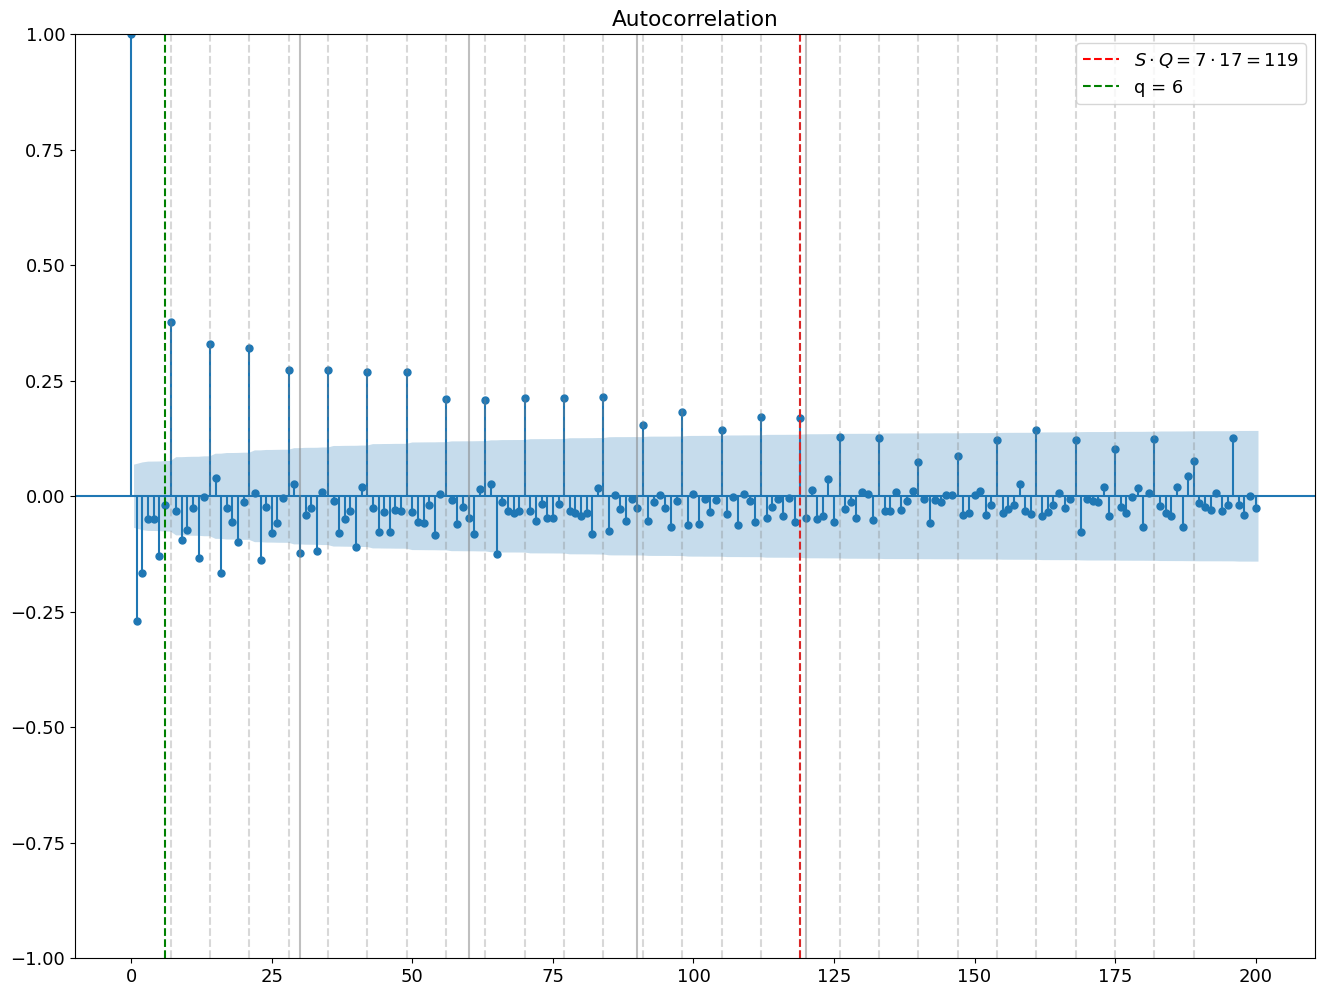

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# оцените начальные приближения параметров

plot_acf(x_boxcox_diff_1, lags=200)

Q = 17
plt.axvline(7 * Q, color='red', linestyle='--', label=f'$S \cdot Q = {S} \cdot {Q} = {S * Q}$')

q = 6
plt.axvline(q, color='green', linestyle='--', label=f'q = {q}')

for i in range(1, 4 * 7):
    plt.axvline(i * 7, color='gray', linestyle='--', alpha=0.3)

for i in range(1, 5):
    plt.axvline(i * 30, color='gray', linestyle='-', alpha=0.5)

plt.legend()

# plt.axvline(x=134)


Начальное значение для параметра Q * S аёт номер последнего сезонного лага, при котором автокорреляция значима.
тут у нас ярко выраженные сезоны - 7 дней.

Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима.

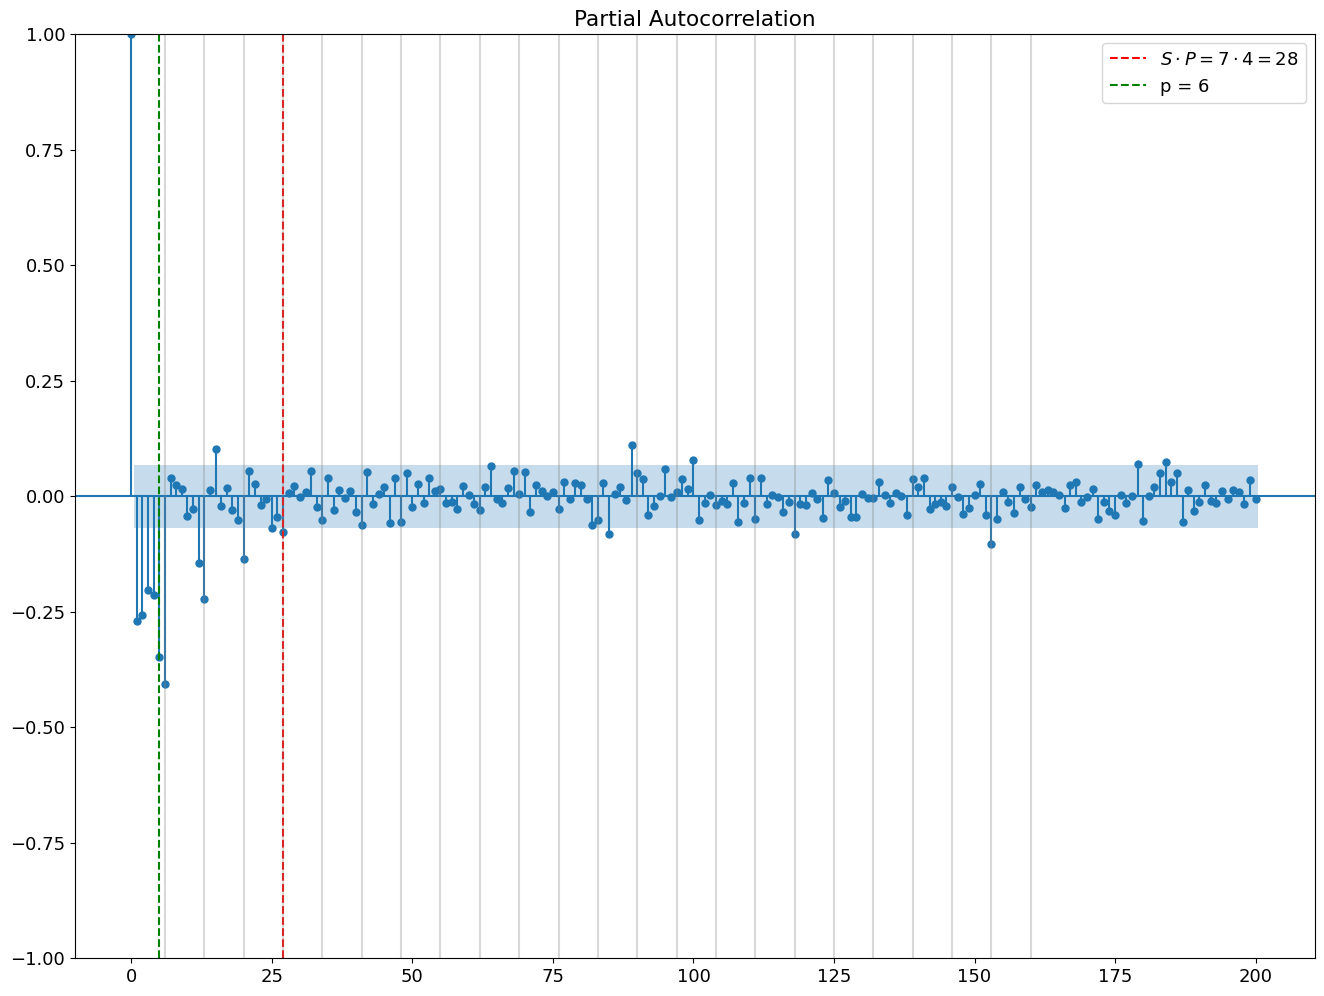

In [ ]:
plot_pacf(x_boxcox_diff_1, lags=200)

shift = 1

P = 4
plt.axvline(S * P - shift, color='red', linestyle='--', label=f'$S \cdot P = {S} \cdot {P} = {S * P}$')

p = 6
plt.axvline(p - shift, color='green', linestyle='--', label=f'p = {p}')

for i in range(1, 4 * 6):
    plt.axvline(i * S - shift, color='gray', linestyle='-', alpha=0.3)

plt.legend()

In [59]:
print(p, d, q)
print(P, D, Q, S)

6 1 6
4 0 17 7


9. Модель SARIMAX
- постройте модель SARIMAX
- Выберите лучшую модель по параметрам
- Визуализируйте предсказание
- Оцените качество предсказания по метрике RMSE

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_test = SARIMAX(
    x_boxcox,
    order=(p, d, q),
    seasonal_order=(P, D, Q, S),   
)
sarimax_fit = sarimax_test.fit()

# sarimax_fit = pickle.load(open('sarimax_fit.pkl', 'rb'))
# with open('sarimax_fit.pkl', 'wb') as f:
#     pickle.dump(sarimax_fit, f)

In [26]:
print(sarimax_fit.aic)
print(sarimax_fit.mae)

-1534.4689385831057
0.07852019719758484


<Axes: xlabel='date'>

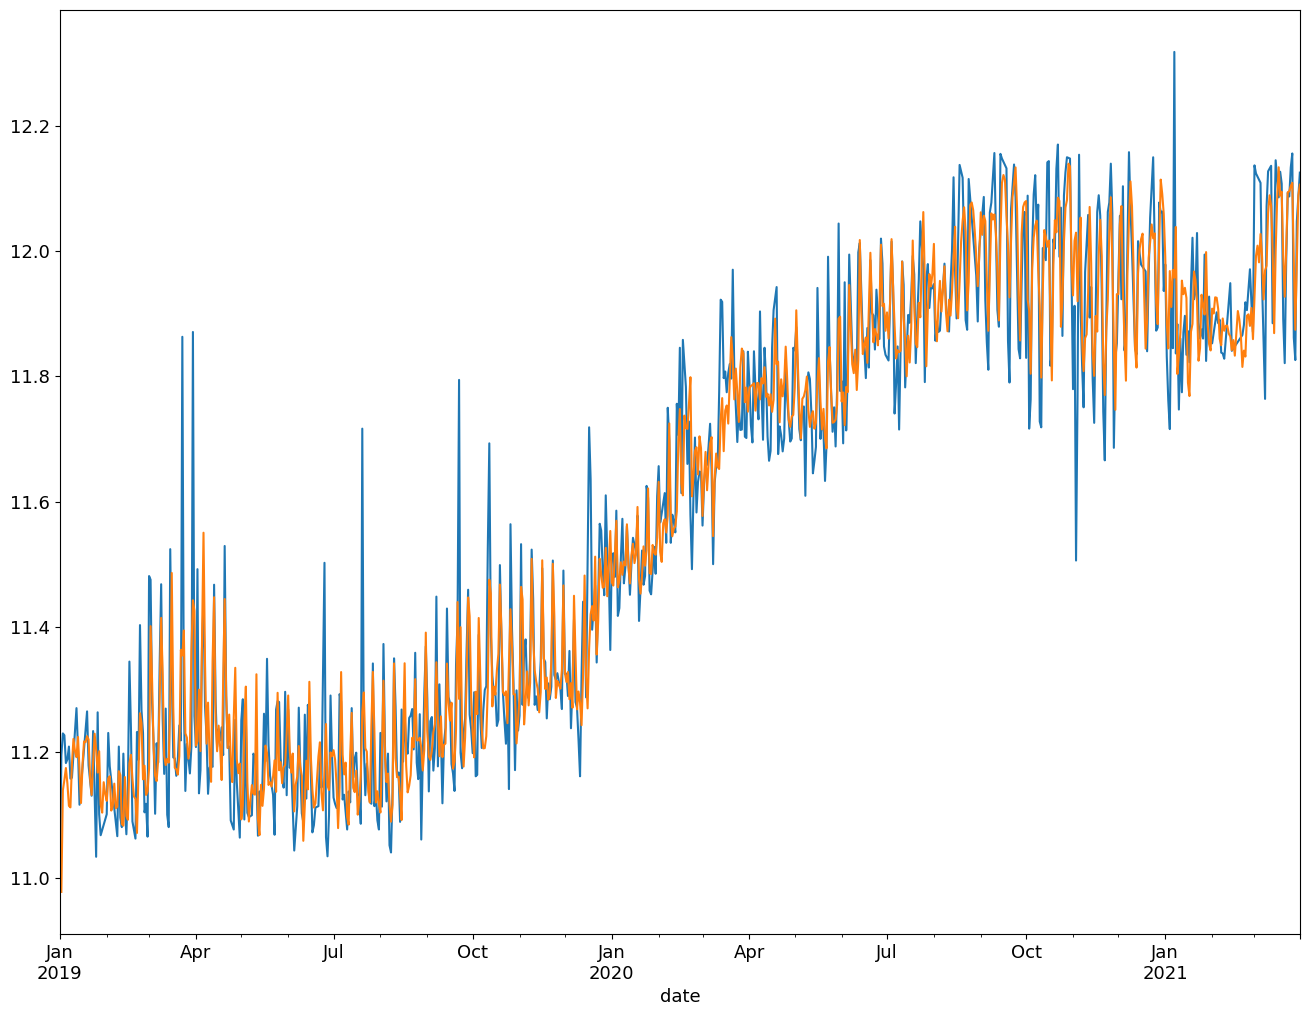

In [ ]:
prediction = sarimax_fit.predict(start=1)
x_boxcox.plot()
prediction.plot()

In [ ]:
# Разбиение данных для обучения и теста
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

folds = TimeSeriesSplit(n_splits=N_SPLITS)

for fold_n, (train_index, test_index) in enumerate(folds.split(x_boxcox)):
    sarimax = SARIMAX(
        x_boxcox[train_index],
        order=(p, d, q),
        seasonal_order=(P, D, Q, S),   
    )
    sarimax_fit = sarimax.fit(disp=True)
    x_boxcox.plot()
    n_steps = len(test_index)
    print(n_steps)
    forecast = sarimax_fit.forecast(n_steps)
    forecast.plot()

    print(len(test_index), len(forecast))
    mae = sklearn.metrics.mean_absolute_error(x_boxcox[test_index], forecast)
    print(mae)
    print()


Добавьте в модель ряды фурье и сравните качество предсказание
ниже приведено лишь несколько рядов, можете себя не ограничивать.

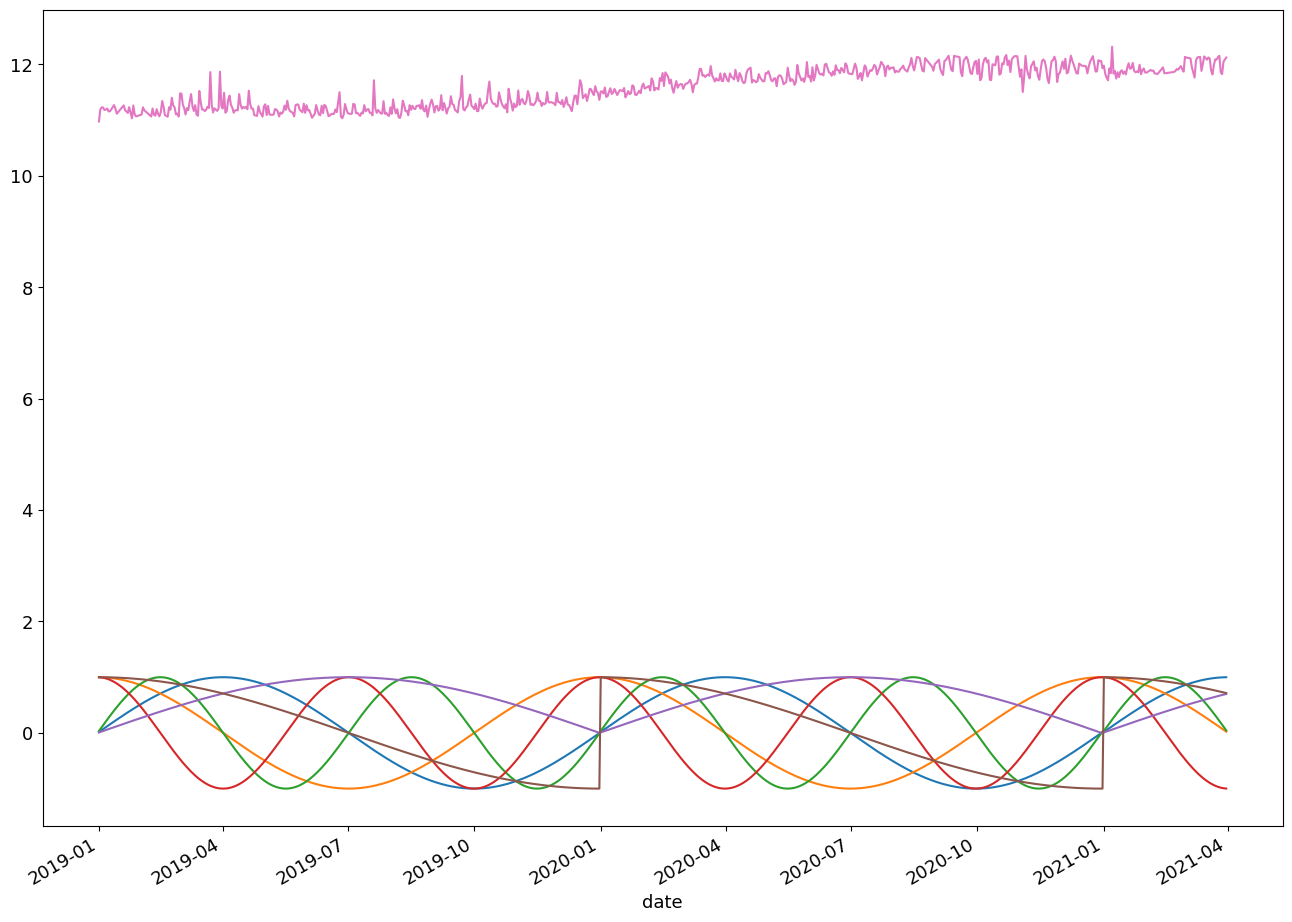

In [69]:
fouriers = [
    np.sin(2 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(2 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.sin(4 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(4 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.sin(np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(np.pi * x_boxcox.index.dayofyear / 365.25)
]

fouriers = [pd.Series(fourier, index=x_boxcox.index) for fourier in fouriers]

for fourier in fouriers:
    plt.plot(fourier)

x_boxcox.plot()

exog = pd.concat(fouriers, axis=1)
exog.columns = ['sin2pi', 'cos2pi', 'sin4pi', 'cos4pi', 'sinpi', 'cospi']

sarimax_test = SARIMAX(
    x_boxcox,
    order=(p, d, q),
    seasonal_order=(P, D, Q, S),
    exog=exog
)

sarimax_fit = sarimax_test.fit()

In [72]:
sarimax_fit.aic, sarimax_fit.mae

(np.float64(-1524.6131844489114), np.float64(0.07927340143876213))

<Axes: xlabel='date'>

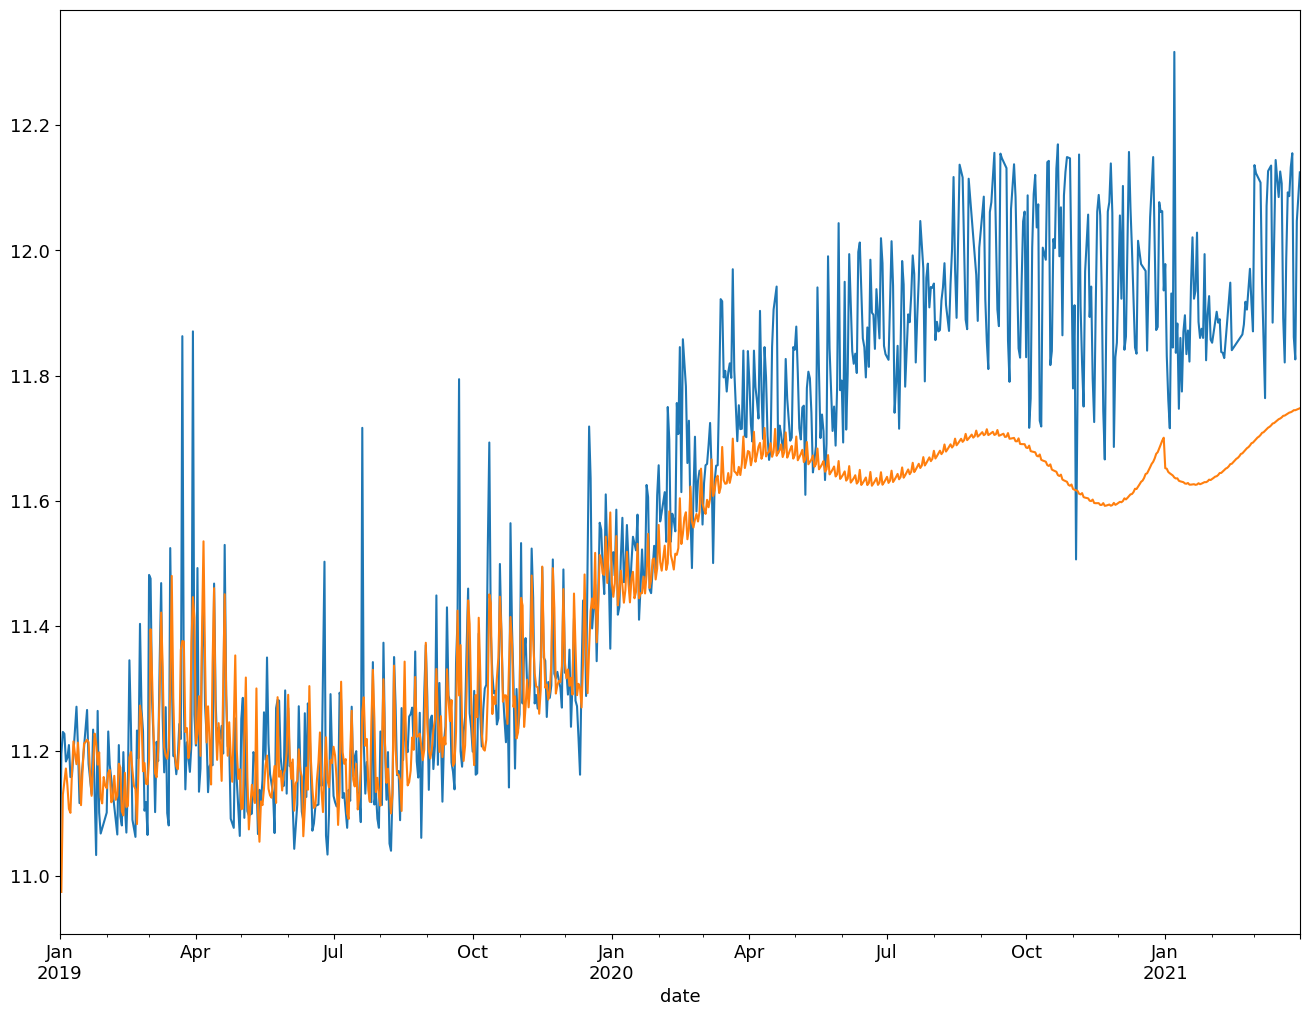

In [ ]:
prediction = sarimax_fit.predict(start=1, dynamic=365)
x_boxcox.plot()
prediction.plot()

Добавьте ряд праздничных и предпраздничных дней. Оцените как он сказывается на качестве предсказания

In [ ]:
fouriers = [
    np.sin(2 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(2 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.sin(4 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(4 * np.pi * x_boxcox.index.dayofyear / 365.25),
    np.sin(np.pi * x_boxcox.index.dayofyear / 365.25),
    np.cos(np.pi * x_boxcox.index.dayofyear / 365.25)
]

fouriers = [pd.Series(fourier, index=x_boxcox.index) for fourier in fouriers]


exog = pd.concat(fouriers, axis=1)
exog.columns = ['sin2pi', 'cos2pi', 'sin4pi', 'cos4pi', 'sinpi', 'cospi']




pd.Series(df['flour'])
exog['is_holiday_or_preholiday'] = pd.Series(df['is_holiday_or_preholiday'].to_numpy().astype(int), index=df['date'])

print(exog)

sarimax_test = SARIMAX(
    x_boxcox,
    order=(p, d, q),
    seasonal_order=(P, D, Q, S),
    exog=exog
)

sarimax_fit = sarimax_test.fit()

              sin2pi    cos2pi    sin4pi    cos4pi     sinpi     cospi  \
date                                                                     
2019-01-01  0.017202  0.999852  0.034398  0.999408  0.008601  0.999963   
2019-01-02  0.034398  0.999408  0.068755  0.997634  0.017202  0.999852   
2019-01-03  0.051584  0.998669  0.103031  0.994678  0.025801  0.999667   
2019-01-04  0.068755  0.997634  0.137185  0.990545  0.034398  0.999408   
2019-01-05  0.085906  0.996303  0.171177  0.985240  0.042993  0.999075   
...              ...       ...       ...       ...       ...       ...   
2021-03-27  0.995827  0.091261  0.181760 -0.983343  0.674069  0.738668   
2021-03-28  0.997250  0.074117  0.147827 -0.989013  0.680398  0.732843   
2021-03-29  0.998377  0.056952  0.113720 -0.993513  0.686676  0.726964   
2021-03-30  0.999209  0.039770  0.079477 -0.996837  0.692903  0.721031   
2021-03-31  0.999745  0.022576  0.045141 -0.998981  0.699079  0.715044   

            is_holiday_or_preholiday 

10. Модель Prophet
* Постройте модель
* Выберите лучшую модель по параметрам
* Визуализируйте предсказание
* Оцените качество предсказания по метрике RMSE

In [140]:
sarimax_fit.aic, sarimax_fit.mae

(np.float64(-5741.94424247492), np.float64(0.00845328708527571))

<Axes: xlabel='date'>

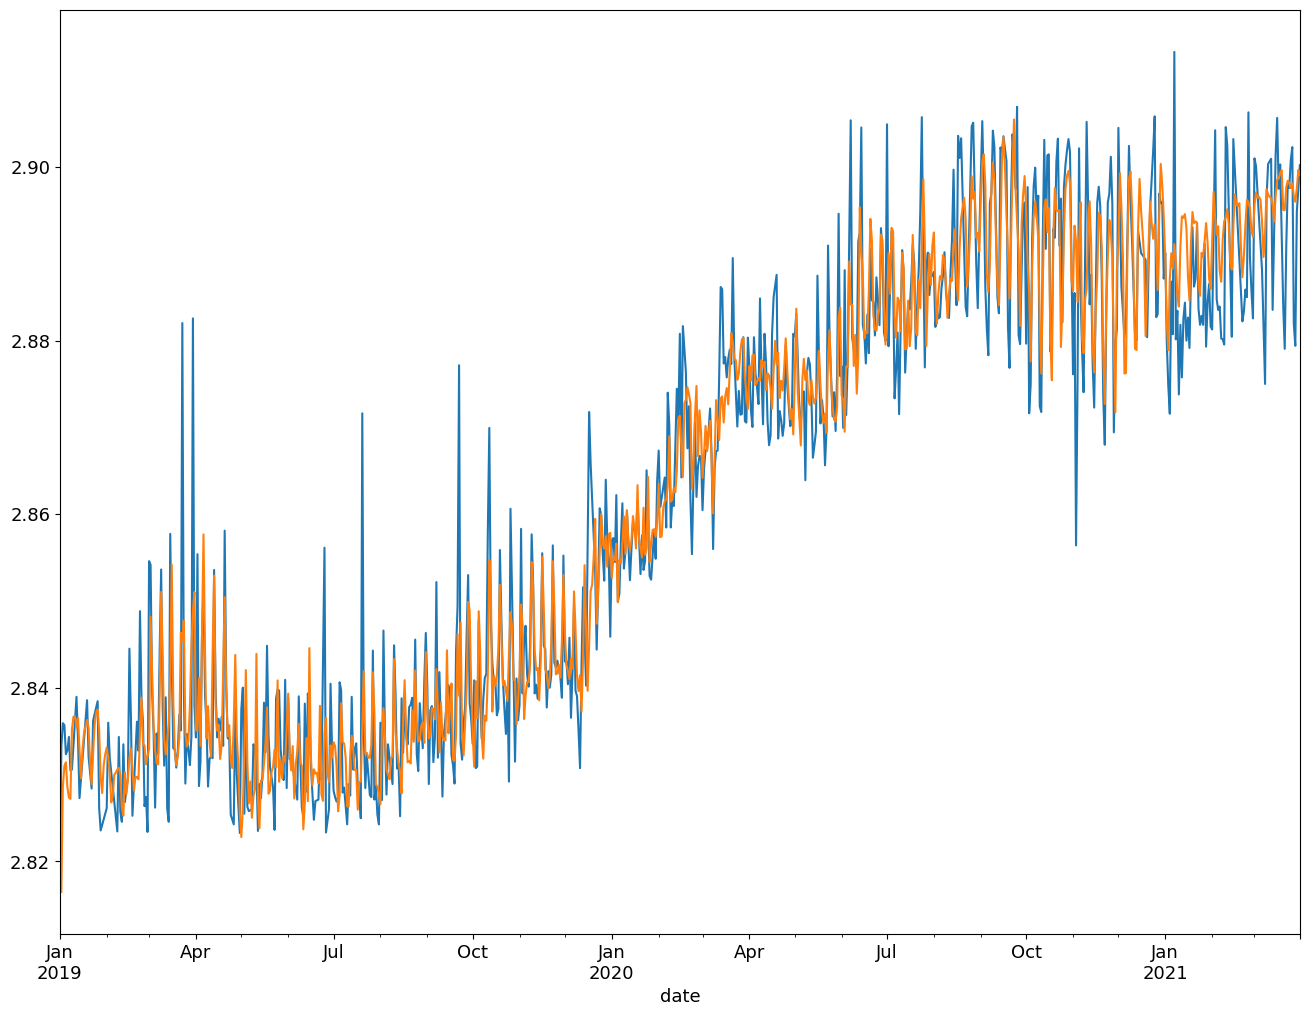

In [ ]:
prediction = sarimax_fit.predict(start=1, dynamic=365*2)
x_boxcox.plot()
prediction.plot()

In [ ]:
from fbprophet import Prophet